
[Method 1] Starting PG Warm-up for LSTM-DPO...
  Iter 200, Cost J = -4.4555
  Iter 400, Cost J = -9.4846
  Iter 600, Cost J = -11.5925
  Iter 800, Cost J = -12.2675
  Iter 1000, Cost J = -12.5491
  Iter 1200, Cost J = -12.6805
  Iter 1400, Cost J = -12.6858
  Iter 1600, Cost J = -12.8513
  Iter 1800, Cost J = -12.8033
  Iter 2000, Cost J = -12.7735
  Iter 2200, Cost J = -12.8417
  Iter 2400, Cost J = -12.7635
  Iter 2600, Cost J = -12.8822
  Iter 2800, Cost J = -12.7473
  Iter 3000, Cost J = -12.8457
  Iter 3200, Cost J = -12.8154
  Iter 3400, Cost J = -12.7894
  Iter 3600, Cost J = -12.8111
  Iter 3800, Cost J = -12.8277
  Iter 4000, Cost J = -12.8029
  Iter 4200, Cost J = -12.7800
  Iter 4400, Cost J = -12.8352
  Iter 4600, Cost J = -12.8128
  Iter 4800, Cost J = -12.7997
  Iter 5000, Cost J = -12.7105
  Iter 5200, Cost J = -12.7702
  Iter 5400, Cost J = -12.8351
  Iter 5600, Cost J = -12.7801
  Iter 5800, Cost J = -12.7724
  Iter 6000, Cost J = -12.8472
  Iter 6200, Cost J = -12.80

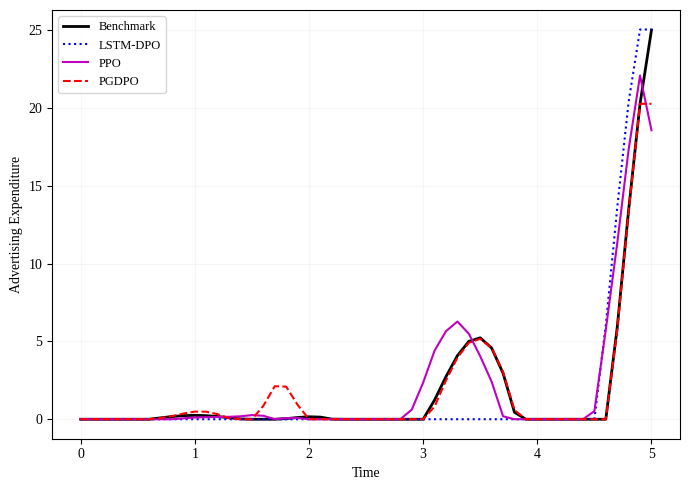

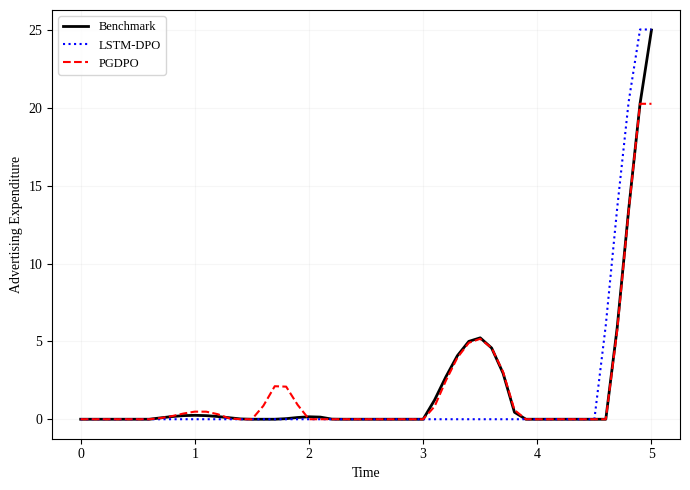

In [ ]:
import math
import time
import random
from typing import Dict, Any, Tuple, List

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

import matplotlib.pyplot as plt


# =============================================================================
# 0. Matplotlib style
# =============================================================================
plt.rcParams.update({
    "pdf.fonttype": 42,
    "font.family": "serif",
    "font.serif": ["Liberation Serif", "FreeSerif", "serif"],
    "font.size": 10,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "mathtext.fontset": "stix",
})


# =============================================================================
# 1. Unified Configuration
# =============================================================================
CFG: Dict[str, Any] = {
    # reproducibility / device / dtype
    "seed": 7,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "dtype": torch.float32,

    # dynamics / cost (advertising)
    "a0": -0.5,
    "b0": 1.0,
    "sigma": 0.2,
    "R": 0.1,
    "S0": -5.0,

    # time grid
    "T": 5.0,
    "N_steps": 50,

    # distributed delay kernel (theta in [-delta, 0])
    "delta": 3.0,
    "H_delay": 20,
    "a1_scale": -10.0,
    "a1_lambda": 1.0,

    # initial history
    "x0": 10.0,
    "x_hist_const": 10.0,

    # -----------------------------
    # Method 1: LSTM-DPO warm-up
    # -----------------------------
    "warmup_batch_size": 256,
    "warmup_iters": 10000,
    "lr_pg": 3e-4,

    # -----------------------------
    # Stage 2 projection
    # -----------------------------
    "N_mc_stage2": 4096,

    # -----------------------------
    # Method 2: STANDARD PPO
    # -----------------------------
    "ppo_num_envs": 256,          # number of parallel episodes per rollout/update
    "ppo_lr": 1e-3,
    "ppo_epochs": 10,
    "ppo_minibatch_size": 1024,
    "ppo_gamma": 1.,
    "ppo_lambda": 0.95,
    "ppo_clip_eps": 0.2,
    "ppo_entropy_coef": 0.01,
    "ppo_value_coef": 0.5,
    "ppo_max_grad_norm": 0.5,

    # training budget
    "ppo_total_episodes": 102400, # # of total episodes

    # Gaussian policy std
    "ppo_init_log_std": math.log(0.6),

    # network size for PPO
    "ppo_hidden": 64,
}

DEVICE = torch.device(CFG["device"])
torch.set_default_dtype(CFG["dtype"])


def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def get_dt(cfg: Dict[str, Any]) -> float:
    return float(cfg["T"]) / float(cfg["N_steps"])


# =============================================================================
# 2. Physics helpers
# =============================================================================
def build_a1_kernel_np(cfg: Dict[str, Any]) -> np.ndarray:
    H = int(cfg["H_delay"])
    delta = float(cfg["delta"])
    dtheta = delta / H
    theta = -delta + dtheta * (np.arange(H) + 0.5)
    a1_vals = float(cfg["a1_scale"]) * np.exp(float(cfg["a1_lambda"]) * theta)
    w = a1_vals * dtheta
    w = w[::-1].copy()
    return w.astype(np.float32)


def build_a1_kernel_torch(cfg: Dict[str, Any], device: torch.device, dtype: torch.dtype) -> torch.Tensor:
    return torch.tensor(build_a1_kernel_np(cfg), device=device, dtype=dtype)


def init_hist_torch(cfg: Dict[str, Any], batch_size: int, device: torch.device, dtype: torch.dtype) -> torch.Tensor:
    H = int(cfg["H_delay"])
    x_hist = torch.full((batch_size, H), float(cfg["x_hist_const"]), device=device, dtype=dtype)
    x_hist[:, 0] = float(cfg["x0"])
    return x_hist


def init_hist_np(cfg: Dict[str, Any]) -> np.ndarray:
    H = int(cfg["H_delay"])
    x_hist = np.full(H, float(cfg["x_hist_const"]), dtype=np.float32)
    x_hist[0] = float(cfg["x0"])
    return x_hist


def delay_integral_torch(w: torch.Tensor, x_hist: torch.Tensor) -> torch.Tensor:
    return torch.sum(w * x_hist, dim=1)


def shift_hist_torch(x_hist: torch.Tensor, x_new: torch.Tensor) -> torch.Tensor:
    return torch.cat([x_new.unsqueeze(1), x_hist[:, :-1]], dim=1)


def env_step_torch(cfg: Dict[str, Any], w: torch.Tensor, x_hist: torch.Tensor, v: torch.Tensor, dt: float, stochastic: bool = True) -> Tuple[torch.Tensor, torch.Tensor]:
    x_curr = x_hist[:, 0]
    integ = delay_integral_torch(w, x_hist)
    drift = float(cfg["a0"]) * x_curr + integ + float(cfg["b0"]) * v

    if stochastic:
        dB = math.sqrt(dt) * torch.randn_like(x_curr)
        x_next = x_curr + drift * dt + float(cfg["sigma"]) * dB
    else:
        x_next = x_curr + drift * dt

    x_hist_next = shift_hist_torch(x_hist, x_next)
    return x_hist_next, x_next


def env_step_np(cfg: Dict[str, Any], w: np.ndarray, x_hist: np.ndarray, v: float, dt: float, stochastic: bool = True) -> Tuple[np.ndarray, float]:
    x_curr = float(x_hist[0])
    integ = float(np.sum(w * x_hist))
    drift = float(cfg["a0"]) * x_curr + integ + float(cfg["b0"]) * v

    if stochastic:
        x_next = x_curr + drift * dt + float(cfg["sigma"]) * np.random.randn() * math.sqrt(dt)
    else:
        x_next = x_curr + drift * dt

    x_hist = np.roll(x_hist, 1)
    x_hist[0] = np.float32(x_next)
    return x_hist, float(x_next)


def running_cost_np(cfg: Dict[str, Any], v: float, dt: float) -> float:
    return float(cfg["R"]) * (v ** 2) * dt


def terminal_cost_np(cfg: Dict[str, Any], x_T: float) -> float:
    return float(cfg["S0"]) * x_T


def running_cost_torch(cfg: Dict[str, Any], v: torch.Tensor, dt: float) -> torch.Tensor:
    return float(cfg["R"]) * (v ** 2) * dt


def terminal_cost_torch(cfg: Dict[str, Any], x_T: torch.Tensor) -> torch.Tensor:
    return float(cfg["S0"]) * x_T


# =============================================================================
# 3. Method 1: LSTM-DPO warm-up
# =============================================================================
class LSTMPolicy(nn.Module):
    def __init__(self, input_size: int = 2, hidden_size: int = 64):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTMCell(input_size, hidden_size)
        self.head = nn.Linear(hidden_size, 1)
        nn.init.constant_(self.head.bias, 1.0)

    def init_hidden(self, batch_size: int, device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:
        h0 = torch.zeros(batch_size, self.hidden_size, device=device)
        c0 = torch.zeros(batch_size, self.hidden_size, device=device)
        return h0, c0

    def forward_step(self, t_norm: torch.Tensor, x_t: torch.Tensor, h: torch.Tensor, c: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        inp = torch.stack([t_norm, x_t], dim=-1)
        h_next, c_next = self.lstm(inp, (h, c))
        v_raw = self.head(h_next).squeeze(-1)
        v = torch.relu(v_raw)
        return v, h_next, c_next


def simulate_pg_batch(policy: LSTMPolicy, cfg: Dict[str, Any], batch_size: int, detach_policy: bool = False, stochastic: bool = True) -> torch.Tensor:
    dt = get_dt(cfg)
    N = int(cfg["N_steps"])
    w = build_a1_kernel_torch(cfg, device=DEVICE, dtype=torch.float32)

    x_hist = init_hist_torch(cfg, batch_size, device=DEVICE, dtype=torch.float32)
    h, c = policy.init_hidden(batch_size, DEVICE)
    cost = torch.zeros(batch_size, device=DEVICE, dtype=torch.float32)

    for n in range(N):
        t_norm = torch.full((batch_size,), (n * dt) / float(cfg["T"]), device=DEVICE, dtype=torch.float32)
        x_curr = x_hist[:, 0]

        if detach_policy:
            with torch.no_grad():
                v, h, c = policy.forward_step(t_norm, x_curr, h, c)
        else:
            v, h, c = policy.forward_step(t_norm, x_curr, h, c)

        cost = cost + running_cost_torch(cfg, v, dt)
        x_hist, _ = env_step_torch(cfg, w, x_hist, v, dt, stochastic=stochastic)

    x_T = x_hist[:, 0]
    cost = cost + terminal_cost_torch(cfg, x_T)
    return cost.mean()


def warmup_train_pg(policy: LSTMPolicy, cfg: Dict[str, Any]) -> LSTMPolicy:
    print("\n[Method 1] Starting PG Warm-up for LSTM-DPO...")
    policy.to(DEVICE).train()
    opt = optim.Adam(policy.parameters(), lr=float(cfg["lr_pg"]))

    for it in range(int(cfg["warmup_iters"])):
        opt.zero_grad()
        J = simulate_pg_batch(policy, cfg, batch_size=int(cfg["warmup_batch_size"]), detach_policy=False, stochastic=True)
        J.backward()
        opt.step()

        if (it + 1) % 200 == 0:
            print(f"  Iter {it+1}, Cost J = {J.item():.4f}")

    return policy


@torch.no_grad()
def rollout_pg_deterministic(policy: LSTMPolicy, cfg: Dict[str, Any]) -> Dict[str, List[torch.Tensor]]:
    dt = get_dt(cfg)
    N = int(cfg["N_steps"])
    w = build_a1_kernel_torch(cfg, device=DEVICE, dtype=torch.float32)

    batch_size = 1
    x_hist = init_hist_torch(cfg, batch_size, device=DEVICE, dtype=torch.float32)
    h, c = policy.init_hidden(batch_size, DEVICE)

    xs, vs, hs, cs, x_hists = [], [], [], [], []

    for n in range(N):
        t_norm = torch.full((batch_size,), (n * dt) / float(cfg["T"]), device=DEVICE, dtype=torch.float32)
        x_curr = x_hist[:, 0]
        v, h, c = policy.forward_step(t_norm, x_curr, h, c)

        xs.append(x_curr.clone())
        vs.append(v.clone())
        hs.append(h.clone())
        cs.append(c.clone())
        x_hists.append(x_hist.clone())

        x_hist, _ = env_step_torch(cfg, w, x_hist, v, dt, stochastic=False)

    return {"xs": xs, "vs": vs, "hs": hs, "cs": cs, "x_hists": x_hists}


# =============================================================================
# 4. PGDPO projection
# =============================================================================
def estimate_costate_from_step(policy: LSTMPolicy, cfg: Dict[str, Any], n0: int, x_hist0: torch.Tensor, h0: torch.Tensor, c0: torch.Tensor) -> torch.Tensor:
    dt = get_dt(cfg)
    N = int(cfg["N_steps"])
    M = int(cfg["N_mc_stage2"])
    w = build_a1_kernel_torch(cfg, device=DEVICE, dtype=torch.float32)

    x0_var = x_hist0[0, 0].detach().clone().requires_grad_(True)
    x_curr_batch = x0_var.expand(M)

    x_hist_rest = x_hist0[:, 1:].repeat(M, 1)
    x_hist = torch.cat([x_curr_batch.unsqueeze(1), x_hist_rest], dim=1)

    h = h0.repeat(M, 1)
    c = c0.repeat(M, 1)

    cost = torch.zeros(M, device=DEVICE, dtype=torch.float32)

    for n in range(n0, N):
        t_norm = torch.full((M,), (n * dt) / float(cfg["T"]), device=DEVICE, dtype=torch.float32)
        v, h, c = policy.forward_step(t_norm, x_hist[:, 0], h, c)
        cost = cost + running_cost_torch(cfg, v, dt)
        x_hist, _ = env_step_torch(cfg, w, x_hist, v, dt, stochastic=True)

    x_T = x_hist[:, 0]
    cost = cost + terminal_cost_torch(cfg, x_T)

    J_mean = cost.mean()
    (grad_x0,) = torch.autograd.grad(J_mean, x0_var, retain_graph=False, create_graph=False)
    return grad_x0.detach()


# =============================================================================
# 5. Analytic PMP benchmark
# =============================================================================
def analytic_pmp_solution(cfg: Dict[str, Any]) -> Tuple[np.ndarray, np.ndarray]:
    dt = get_dt(cfg)
    N = int(cfg["N_steps"])
    H = int(cfg["H_delay"])

    w = build_a1_kernel_np(cfg)

    A = np.zeros((H, H), dtype=np.float64)
    A[0, 0] = 1.0 + dt * float(cfg["a0"]) + dt * float(w[0])
    A[0, 1:] = dt * w[1:]
    for i in range(1, H):
        A[i, i - 1] = 1.0

    Y = np.zeros((N + 1, H), dtype=np.float64)
    Y[N, 0] = float(cfg["S0"])

    AT = A.T
    for n in reversed(range(N)):
        Y[n] = AT @ Y[n + 1]

    v_star = np.zeros(N + 1, dtype=np.float64)
    for n in range(N + 1):
        v_un = -(float(cfg["b0"]) / (2.0 * float(cfg["R"]))) * Y[n, 0]
        v_star[n] = max(0.0, v_un)

    t_grid = np.linspace(0.0, float(cfg["T"]), N + 1)
    return t_grid, v_star


# =============================================================================
# 6. Method 2: PPO
# =============================================================================

class PPOActorCritic(nn.Module):
    """PPO network for distributed state-delay: input is x_hist window (B,H_delay)."""
    def __init__(self, hidden_size: int, init_log_std: float):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.actor_mu = nn.Linear(hidden_size, 1)
        self.critic = nn.Linear(hidden_size, 1)

        # Gaussian std in raw-action space (scalar, shared)
        self.log_std = nn.Parameter(torch.tensor([init_log_std], dtype=torch.float32))

        nn.init.constant_(self.actor_mu.bias, 0.5)

    def _features(self, x_hist: torch.Tensor) -> torch.Tensor:
        # x_hist: (B,H) -> (B,H,1)
        x = x_hist.unsqueeze(-1)
        _, (h_n, _) = self.lstm(x)
        feat = F.relu(self.fc(h_n[-1]))
        return feat

    def dist_and_value(self, x_hist: torch.Tensor):
        feat = self._features(x_hist)
        mu = self.actor_mu(feat)                 # (B,1)
        val = self.critic(feat).squeeze(-1)      # (B,)
        std = torch.exp(self.log_std).expand_as(mu)
        dist = Normal(mu, std)
        return dist, val


@torch.no_grad()
def _ppo_rollout(policy: PPOActorCritic, cfg: Dict[str, Any], w: torch.Tensor, batch_envs: int):
    dt = get_dt(cfg)
    T_steps = int(cfg["N_steps"])
    H = int(cfg["H_delay"])

    # init envs
    x_hist = init_hist_torch(cfg, batch_envs, device=DEVICE, dtype=torch.float32)

    X_list, A_list, logP_list, V_list, R_list = [], [], [], [], []

    for t in range(T_steps):
        X_list.append(x_hist.clone())

        dist, v = policy.dist_and_value(x_hist)     # v: (B,)
        raw = dist.sample()                         # (B,1)
        logp = dist.log_prob(raw).squeeze(-1)       # (B,)

        v_exec = torch.relu(raw.squeeze(-1))        # executed control (B,)

        # step env (stochastic)
        x_hist, x_next = env_step_torch(cfg, w, x_hist, v_exec, dt, stochastic=True)

        # reward (same sign convention as your old PPO code)
        # step reward = - running_cost; terminal add -terminal_cost at last step
        r = -float(cfg["R"]) * (v_exec ** 2) * dt
        if t == T_steps - 1:
            r = r + (-terminal_cost_torch(cfg, x_next))

        A_list.append(raw.clone())          # (B,1)
        logP_list.append(logp.clone())      # (B,)
        V_list.append(v.clone())            # (B,)
        R_list.append(r.clone())            # (B,)

    X = torch.stack(X_list, dim=0)          # (T,B,H)
    A = torch.stack(A_list, dim=0)          # (T,B,1)
    logP = torch.stack(logP_list, dim=0)    # (T,B)
    V = torch.stack(V_list, dim=0)          # (T,B)
    R = torch.stack(R_list, dim=0)          # (T,B)
    return X, A, logP, V, R


def _ppo_gae(cfg: Dict[str, Any], rewards: torch.Tensor, values: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    gamma = float(cfg["ppo_gamma"])
    lam = float(cfg["ppo_lambda"])

    T_steps, B = rewards.shape
    adv = torch.zeros(T_steps, B, device=rewards.device)
    gae = torch.zeros(B, device=rewards.device)

    for t in reversed(range(T_steps)):
        v_t = values[t]
        if t == T_steps - 1:
            v_next = torch.zeros_like(v_t)
            nonterm = 0.0
        else:
            v_next = values[t + 1]
            nonterm = 1.0

        delta = rewards[t] + gamma * v_next * nonterm - v_t
        gae = delta + gamma * lam * nonterm * gae
        adv[t] = gae

    ret = adv + values
    return ret, adv


def train_ppo_standard(cfg: Dict[str, Any], device) -> PPOActorCritic:
    print("\n[Method 2] Starting STANDARD PPO Training...")

    # keep your call signature: device can be 'cuda:5' string
    dev = torch.device(device)

    policy = PPOActorCritic(
        hidden_size=int(cfg["ppo_hidden"]),
        init_log_std=float(cfg["ppo_init_log_std"]),
    ).to(dev)

    optimizer = optim.Adam(policy.parameters(), lr=float(cfg["ppo_lr"]))

    # kernel on device
    w = build_a1_kernel_torch(cfg, device=dev, dtype=torch.float32)

    # training budget: total episodes across all envs
    total_episodes = int(cfg["ppo_total_episodes"])
    envs = int(cfg["ppo_num_envs"])

    epochs = int(cfg["ppo_epochs"])
    minibatch_size = int(cfg["ppo_minibatch_size"])

    clip_eps = float(cfg["ppo_clip_eps"])
    ent_coef = float(cfg["ppo_entropy_coef"])
    vf_coef = float(cfg["ppo_value_coef"])
    max_gn = float(cfg["ppo_max_grad_norm"])

    episodes_done = 0
    update_idx = 0

    while episodes_done < total_episodes:
        update_idx += 1
        batch_envs = min(envs, total_episodes - episodes_done)
        episodes_done += batch_envs

        policy.eval()
        with torch.no_grad():
            X, A, logP_old, V, R = _ppo_rollout(policy, cfg, w, batch_envs=batch_envs)

        # GAE + returns
        returns, adv = _ppo_gae(cfg, R, V)

        T_steps, B, H = X.shape
        Xf = X.reshape(T_steps * B, H)
        Af = A.reshape(T_steps * B, 1)
        logP_old_f = logP_old.reshape(T_steps * B).detach()
        returns_f = returns.reshape(T_steps * B).detach()
        adv_f = adv.reshape(T_steps * B).detach()

        # advantage normalization
        adv_f = (adv_f - adv_f.mean()) / (adv_f.std() + 1e-8)

        dataset_size = Xf.size(0)
        mb = min(minibatch_size, dataset_size)

        policy.train()
        for _ in range(epochs):
            perm = torch.randperm(dataset_size, device=dev)
            for start in range(0, dataset_size, mb):
                idx = perm[start:start + mb]

                dist, v_new = policy.dist_and_value(Xf[idx])
                logP_new = dist.log_prob(Af[idx]).squeeze(-1)     # (mb,)
                entropy = dist.entropy().squeeze(-1).mean()

                ratio = torch.exp(logP_new - logP_old_f[idx])
                surr1 = ratio * adv_f[idx]
                surr2 = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * adv_f[idx]
                actor_loss = -torch.min(surr1, surr2).mean()

                critic_loss = (v_new - returns_f[idx]).pow(2).mean()

                loss = actor_loss + vf_coef * critic_loss - ent_coef * entropy

                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy.parameters(), max_gn)
                optimizer.step()

        if update_idx % 1 == 0:
            avg_obj = float((-R).sum(dim=0).mean().item())  # rough diagnostic (sum of costs)
            print(f"  [PPO] update {update_idx} | episodes_done={episodes_done}/{total_episodes} | avg_cost_sum≈{avg_obj:.4f}")

    return policy


@torch.no_grad()
def eval_ppo_deterministic(policy: PPOActorCritic, cfg: Dict[str, Any]) -> np.ndarray:
    policy.eval()
    dt = get_dt(cfg)
    N = int(cfg["N_steps"])
    w = build_a1_kernel_torch(cfg, device=DEVICE, dtype=torch.float32)

    x_hist = init_hist_torch(cfg, batch_size=1, device=DEVICE, dtype=torch.float32)
    v_traj: List[float] = []

    for t in range(N + 1):
        dist, _ = policy.dist_and_value(x_hist)      # dist.mean: (1,1)
        mu = dist.mean.squeeze(-1)                   # (1,)
        v = torch.relu(mu)                           # (1,)
        v_traj.append(float(v.item()))

        if t < N:
            x_hist, _ = env_step_torch(cfg, w, x_hist, v, dt, stochastic=False)

    return np.array(v_traj, dtype=np.float64)


# =============================================================================
# 7. Metrics / Plot
# =============================================================================
def compute_metrics(gt: np.ndarray, pred: np.ndarray) -> Tuple[float, float]:
    m = min(len(gt), len(pred))
    rmse = float(np.sqrt(np.mean((pred[:m] - gt[:m]) ** 2)))
    mae = float(np.mean(np.abs(pred[:m] - gt[:m])))
    return rmse, mae


def print_metrics_table(gt: np.ndarray, preds: Dict[str, np.ndarray]) -> None:
    print(f"\n{'Algorithm':<15} | {'RMSE':<10} | {'MAE':<10}")
    print("-" * 42)
    for name, arr in preds.items():
        rmse, mae = compute_metrics(gt, arr)
        print(f"{name:<15} | {rmse:.5f}    | {mae:.5f}")


def plot_controls(t_grid: np.ndarray,
                  v_star: np.ndarray,
                  v_lstm_dpo: np.ndarray,
                  v_ppo: np.ndarray,
                  v_pgdpo: np.ndarray,
                  ppo: bool) -> None:
    plt.figure(figsize=(7, 5))
    plt.plot(t_grid, v_star, "k-", lw=2, label="Benchmark")
    plt.plot(t_grid, v_lstm_dpo, "b:", label="LSTM-DPO")
    if ppo:
        plt.plot(t_grid, v_ppo, "m-", label="PPO")
    plt.plot(t_grid, v_pgdpo, "r--", label="PGDPO")
    plt.xlabel("Time")
    plt.ylabel("Advertising Expenditure")
    plt.legend()
    plt.grid(alpha=0.1)
    plt.tight_layout()
    if ppo:
        plt.savefig("Benchmark3_control_ppo.pdf", bbox_inches="tight")
    else:
        plt.savefig("Benchmark3_control.pdf", bbox_inches="tight")
    plt.show()


# =============================================================================
# 8. Final comparison
# =============================================================================
def run_full_comparison(policy_pg: LSTMPolicy, ppo_policy: PPOActorCritic, cfg: Dict[str, Any]) -> None:
    print("\n=== Running Final Comparison ===")

    t_grid, v_star = analytic_pmp_solution(cfg)

    # LSTM-DPO deterministic rollout
    policy_pg.eval()
    rollout = rollout_pg_deterministic(policy_pg, cfg)

    v_pg_raw: List[float] = []
    v_pgdpo: List[float] = []

    print("  Calculating PGDPO projections...")
    N = int(cfg["N_steps"])

    for n in range(N):
        if n == 0:
            t_start = time.time()

        v_net = float(rollout["vs"][n].item())

        lam = estimate_costate_from_step(
            policy_pg, cfg, n, rollout["x_hists"][n], rollout["hs"][n], rollout["cs"][n]
        )

        v_proj = max(0.0, -(float(cfg["b0"]) / (2.0 * float(cfg["R"]))) * float(lam.item()))

        if n == 0:
            t_end = time.time()
            print(f"--> [TIME CHECK] 1 Step Projection Time: {t_end - t_start:.6f} seconds")

        v_pg_raw.append(v_net)
        v_pgdpo.append(v_proj)

    v_pg_raw.append(v_pg_raw[-1])
    v_pgdpo.append(v_pgdpo[-1])

    # PPO deterministic evaluation
    print("  Calculating PPO trajectory (deterministic)...")
    v_ppo = eval_ppo_deterministic(ppo_policy, cfg)

    # align lengths
    v_pg_raw_np = np.array(v_pg_raw, dtype=np.float64)
    v_pgdpo_np = np.array(v_pgdpo, dtype=np.float64)

    m = min(len(v_star), len(v_pg_raw_np), len(v_pgdpo_np), len(v_ppo), len(t_grid))
    v_star_m = v_star[:m]
    v_lstm_m = v_pg_raw_np[:m]
    v_pgdpo_m = v_pgdpo_np[:m]
    v_ppo_m = v_ppo[:m]
    t_m = t_grid[:m]

    preds = {
        "LSTM-DPO": v_lstm_m,
        "PPO": v_ppo_m,
        "PGDPO": v_pgdpo_m,
    }
    print_metrics_table(v_star_m, preds)

    plot_controls(t_m, v_star_m, v_lstm_m, v_ppo_m, v_pgdpo_m,ppo=True)
    plot_controls(t_m, v_star_m, v_lstm_m, v_ppo_m, v_pgdpo_m,ppo=False)


def main() -> None:
    set_seed(int(CFG["seed"]))

    # 1) LSTM-DPO warm-up (unchanged)
    policy_pg = LSTMPolicy(input_size=2, hidden_size=64)
    policy_pg = warmup_train_pg(policy_pg, CFG)

    # 2) Standard PPO training (new)
    ppo_policy = train_ppo_standard(CFG, CFG["device"])

    # 3) Final comparison
    run_full_comparison(policy_pg, ppo_policy, CFG)


if __name__ == "__main__":
    main()
